<h1>Tweet Binary Classification (Disaster or Not Disaster)</h1>
<a>https://github.com/mrdbourke/tensorflow-deep-learning</a>

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from tqdm.keras import TqdmCallback
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
%%capture

!wget -nc "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
!unzip -o "nlp_getting_started"

In [ ]:
train_df = pd.read_csv('train.csv')
train_df = train_df.sample(frac=1, random_state=42)
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_df['text'].to_numpy(),
                                                  train_df['target'].to_numpy(),
                                                  test_size=0.1,
                                                  random_state=42)
print(x_train.shape, x_val.shape)

(6851,) (762,)


# Tokenization and Embedding

In [ ]:
np.mean([len(i.split()) for i in x_train])

14.901036345059115

In [ ]:
max_vocab_length = 10_000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

text_vectorizer.adapt(x_train)

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(words_in_vocab[:5])
print(words_in_vocab[-5:])

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
text_vectorizer(['There is a flood in my street.!'])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

embedding(text_vectorizer(['There is a flood in my street.!']))

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00929014, -0.0270105 ,  0.02950748, ...,  0.02488491,
          0.02128729,  0.03216967],
        [ 0.00226194,  0.02574493,  0.031356  , ..., -0.00222156,
         -0.02514851, -0.03955914],
        [ 0.01239922,  0.02847851, -0.00632691, ...,  0.02757875,
         -0.00082513,  0.02829385],
        ...,
        [ 0.04380101, -0.02731644,  0.0415005 , ...,  0.01092632,
         -0.02431204,  0.04327062],
        [ 0.04380101, -0.02731644,  0.0415005 , ...,  0.01092632,
         -0.02431204,  0.04327062],
        [ 0.04380101, -0.02731644,  0.0415005 , ...,  0.01092632,
         -0.02431204,  0.04327062]]], dtype=float32)>

In [ ]:
def calculate_results(model, x_val, y_val):

    # Predict
    pred = model.predict(x_val)
    pred = tf.squeeze(tf.round(pred))

    # Calculate the statistics
    acc = accuracy_score(y_val, pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average="weighted")
    return {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}

# 0. Naive Bayes with TF-IDF

In [ ]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model0_results = calculate_results(model_0, x_val, y_val)
model0_results

{'accuracy': 0.7926509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# 1. Feed Forward Neural Network

In [ ]:
# Build the Model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_1.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model1_results = calculate_results(model_1, x_val, y_val)
model1_results

{'accuracy': 0.7755905511811023,
 'f1': 0.770997050538307,
 'precision': 0.7841484675632434,
 'recall': 0.7755905511811023}

# 2. LSTM

In [ ]:
# Build the Model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_2.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model2_results = calculate_results(model_2, x_val, y_val)
model2_results

{'accuracy': 0.7664041994750657,
 'f1': 0.7624482447780866,
 'precision': 0.7720954881828903,
 'recall': 0.7664041994750657}

# 3. GRU

In [ ]:
# Build the Model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_3.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model3_results = calculate_results(model_3, x_val, y_val)
model3_results

{'accuracy': 0.7650918635170604,
 'f1': 0.7583885606321948,
 'precision': 0.7786759490843812,
 'recall': 0.7650918635170604}

# 4. Bidirectional LSTM

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_4.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model4_results = calculate_results(model_4, x_val, y_val)
model4_results

{'accuracy': 0.7716535433070866,
 'f1': 0.7691811868378113,
 'precision': 0.7741380916586217,
 'recall': 0.7716535433070866}

# 5. 1D CNN

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_5.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model5_results = calculate_results(model_5, x_val, y_val)
model5_results

{'accuracy': 0.7664041994750657,
 'f1': 0.765614809581862,
 'precision': 0.7661181993158156,
 'recall': 0.7664041994750657}

# 6. Transfer Learning

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed(['There is a flood in my street.!'])[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01602834,  0.01068852,  0.02425465, -0.01405768,  0.01434425,
        0.08292625,  0.01963371,  0.06160141, -0.00352699, -0.01216414,
        0.00978648, -0.01248496,  0.01232345,  0.09748451,  0.06141113,
       -0.03728351,  0.01860887, -0.04669854,  0.00413914, -0.06363908,
       -0.02469896,  0.02713691,  0.02284444, -0.00210026, -0.00630592,
       -0.03964961,  0.02220408,  0.00115075, -0.03132177,  0.00119528,
       -0.04012547,  0.04561895, -0.01530597, -0.00175915,  0.02173136,
       -0.08450425,  0.03340026,  0.04604554, -0.02480249, -0.08681663,
        0.00702694, -0.00770479, -0.01434537,  0.07814164, -0.10676058,
       -0.05152992, -0.00858158, -0.03232233, -0.03871096,  0.0258147 ],
      dtype=float32)>

In [ ]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model_6.fit(x=x_train,
                y=y_train,
                validation_data=(x_val, y_val),
                epochs=5,
                callbacks=[TqdmCallback(verbose=0)], verbose=0)

In [ ]:
model6_results = calculate_results(model_6, x_val, y_val)
model6_results

{'accuracy': 0.8162729658792651,
 'f1': 0.8156520974239365,
 'precision': 0.8164114972064018,
 'recall': 0.8162729658792651}

# Comparision

In [ ]:
stats = pd.DataFrame({'baseline': model0_results,
                      'simple_dense': model1_results,
                      'LSTM': model2_results,
                      'GRU': model3_results,
                      'Bidirectional': model4_results,
                      'Conv1d': model5_results,
                      'Transfer Learning': model6_results}).T
stats

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.775591,0.784148,0.775591,0.770997
LSTM,0.766404,0.772095,0.766404,0.762448
GRU,0.765092,0.778676,0.765092,0.758389
Bidirectional,0.771654,0.774138,0.771654,0.769181
Conv1d,0.766404,0.766118,0.766404,0.765615
Transfer Learning,0.816273,0.816411,0.816273,0.815652


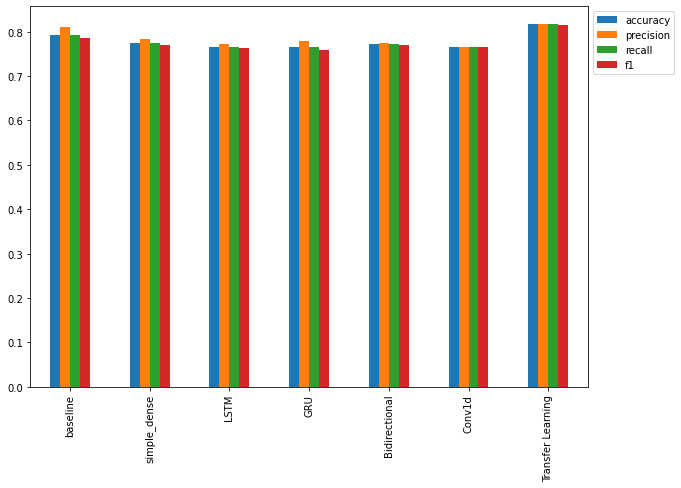

In [ ]:
stats.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));